# Portfolio Optimization
This tool will help you find a good mix of stocks, ETFs and mutual funds for a given portfolio.

## Getting Started:

 - You will need a portfolio file, in .csv format. You can export a portfolio from your brokerage, or you can compile a simple csv file. The portfolio must have the following items:
		 - Symbol: the symbol of the asset (for example, *AAPL* for Apple)
		 - Quantity: a decimal number showing the total number of shares you hold for that symbol.
		 - Market Value: this can be the market value of the assets
		 - One blank line following the assets.
		 - After that blank line, a line with "Account Total" in the Symbol column, and the total market value of the portfolio in the "Market Value" column.

## Prompts

 - **Path for the CSV file** - no quotes, use forward slashes only:
	 - Windows: C:/Users/username/Downloads/portfolio.csv
	 - MacOS /Users/username/directory/portfolio.csv
 - **Your Risk Tolerance**
	 - A decimal number between 0 and 1, showing the amount of risk you are willing to tolerate
	 - For example, 0.15 is 15% risk
	 - The program uses volatility as a proxy for risk. It will compare the daily change in closing prices to determine the risk for the number of days chosen.
 - **Number of Trading Days**
	 - There are normally 252 trading days in the US
	 - Enter a number of trading days to use for calculating risk.
	 - The program will choose the latest number of trading days, from the most recent day back.
	 - Experiment with different numbers of days.
 - **Number of Simulations**
	 - Enter a number of times you'd like the program to create portfolios based on the other inputs.
	 - This is a Monte Carlo simulation. The best performing portfolio from the number of simulations ran that does not exceed your risk tolerance will be displayed.

**Notes**
- Every time you run the program, you will get different results.
- Consult a professional before trading if you are not comfortable with the concepts.

In [12]:
# Imports
import os

# Third-party imports
import pandas as pd
from dotenv import load_dotenv

import functions as f

In [13]:
# Load environment variables (stuff that doesn't change often)
load_dotenv()

API_KEY = os.getenv('FMPKEY')   

RF = (lambda x: x[0]["month3"] / 100)(f.get_treasury_data(API_KEY))  # 3 Month Treasury Rate

TRADING_DAYS = 252  # Number of trading days in a year

In [14]:
# These need to be prompted at each run

# Prompt for CSV file path
file_path = input("Enter the path for the CSV file: ")

# Read CSV file
current_portfolio = pd.read_csv(file_path, skiprows=2)

ACCT = float(current_portfolio['Market Value'].replace('[\$,]', '', regex=True).iloc[-1]) # Account balance
print(ACCT)

current_portfolio = current_portfolio[~current_portfolio['Symbol'].isin(['Cash & Cash Investments', 'Account Total'])] # Remove cash and total rows
current_portfolio = current_portfolio[['Symbol', 'Quantity']].rename(columns={'Quantity': 'Shares'})
current_portfolio['Shares'] = pd.to_numeric(current_portfolio['Shares'], errors='coerce')

STOCKS = current_portfolio['Symbol'].unique().tolist()
print(STOCKS)

RISK = float(input("What is your risk tolerance? (0.0 - 1.0): "))
#RISK = 0.2  # Risk tolerance

NUMBER_OF_DAYS = int(input("How many trading days would you like to simulate? (252 per year): "))
#NUMBER_OF_DAYS = 300  # Number of days to simulate (history)

NUMBER_OF_PORTFOLIOS = int(input("How many portfolio simulations would you like to use? (100): "))
#NUMBER_OF_PORTFOLIOS = 100  # Number of portfolios to simulate



7567.49
['EOG', 'MET', 'NVDA', 'TSLA', 'BULZ', 'EELV', 'EFG', 'EFV', 'FBL', 'FLSW', 'FNGO', 'FTEC', 'IFRA', 'IVE', 'MTUM', 'NVDL', 'SCHA', 'SCHX', 'SGDJ', 'SPDW', 'SPSM', 'SPYG', 'SQQQ', 'USMV', 'XES', 'XLB', 'XLE', 'XOP']


In [15]:
# Get the price history for all stocks and ETFs
stock_history = f.get_stock_history(STOCKS, NUMBER_OF_DAYS, API_KEY)

In [16]:
# Get the daily return (price difference) for all stocks and ETFs
return_stocks = f.get_return_stocks(stock_history)

In [17]:
portfolio_dfs = f.get_montecarlo_simulation(NUMBER_OF_PORTFOLIOS, STOCKS, return_stocks, TRADING_DAYS, RF, RISK)

In [18]:
recommendations = f.get_recommendations(portfolio_dfs, current_portfolio, ACCT, STOCKS, stock_history)

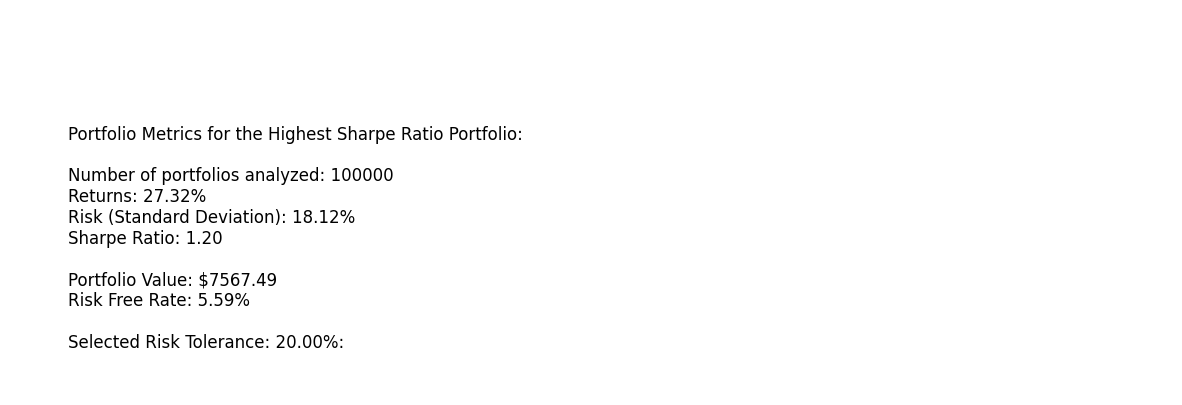

In [19]:
f.plot_portfolio_metrics(portfolio_dfs, NUMBER_OF_PORTFOLIOS, ACCT, RF, RISK)

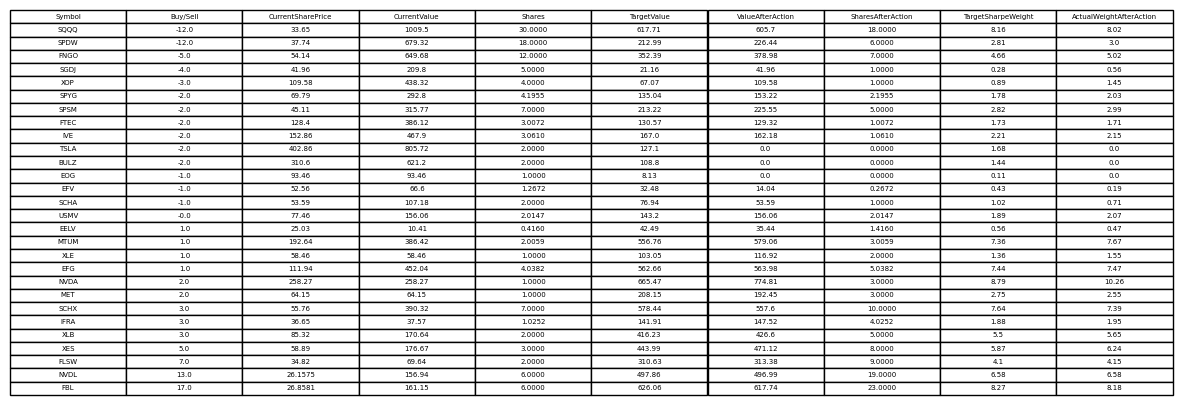

In [20]:
f.plot_portfolio_changes(recommendations)

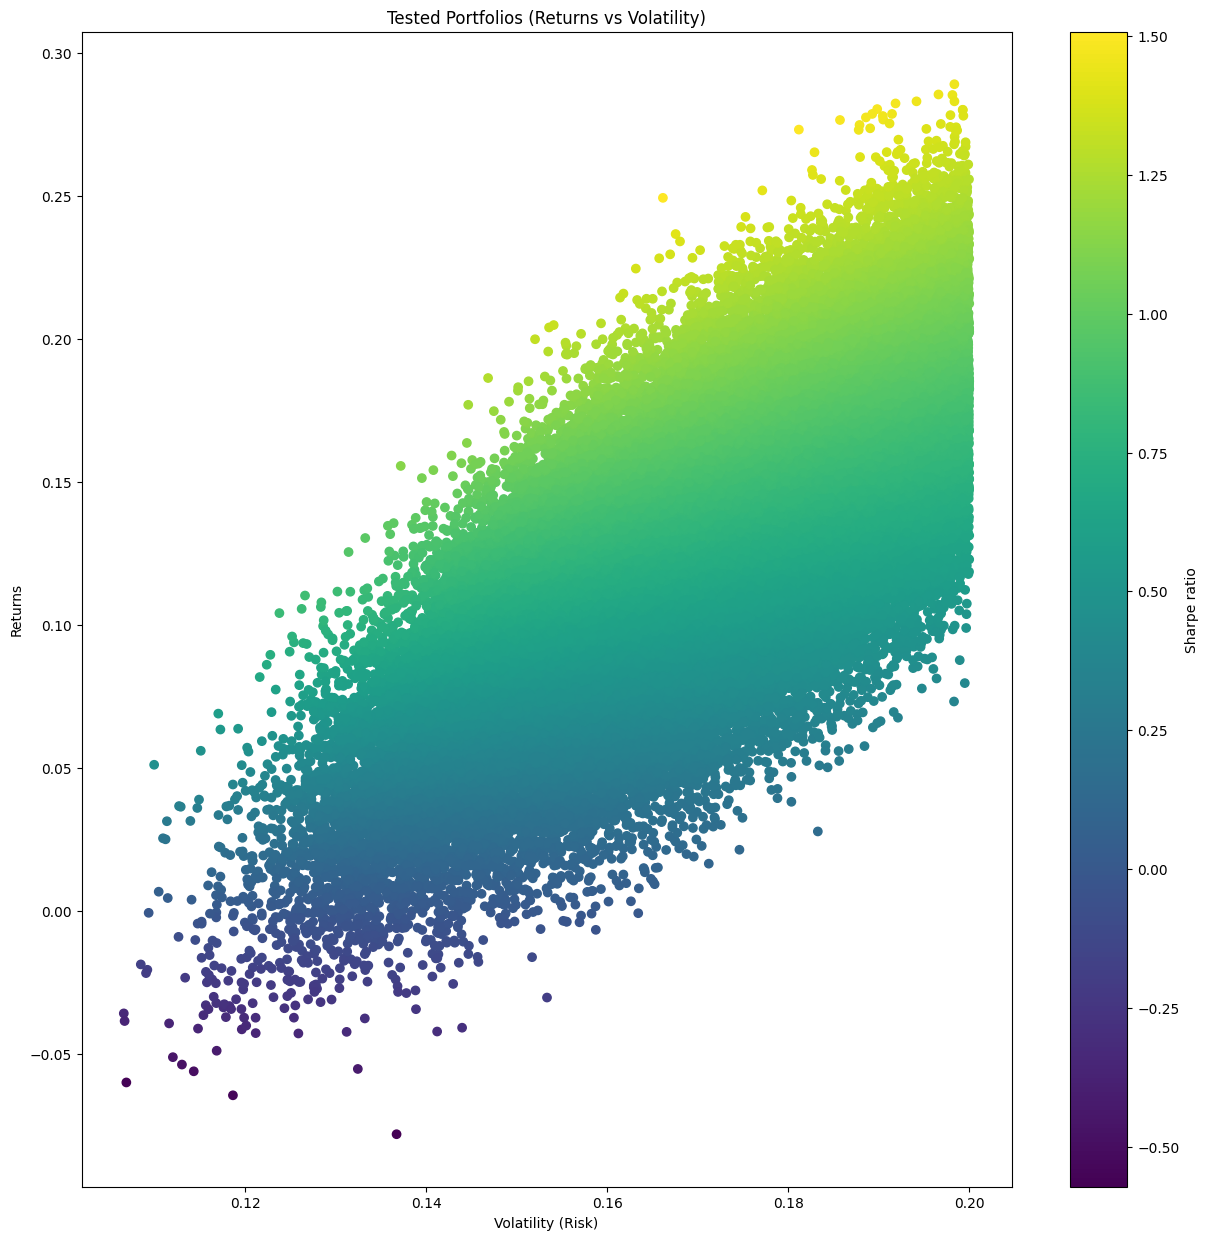

In [21]:
f.plot_risk_scatterplot(portfolio_dfs)

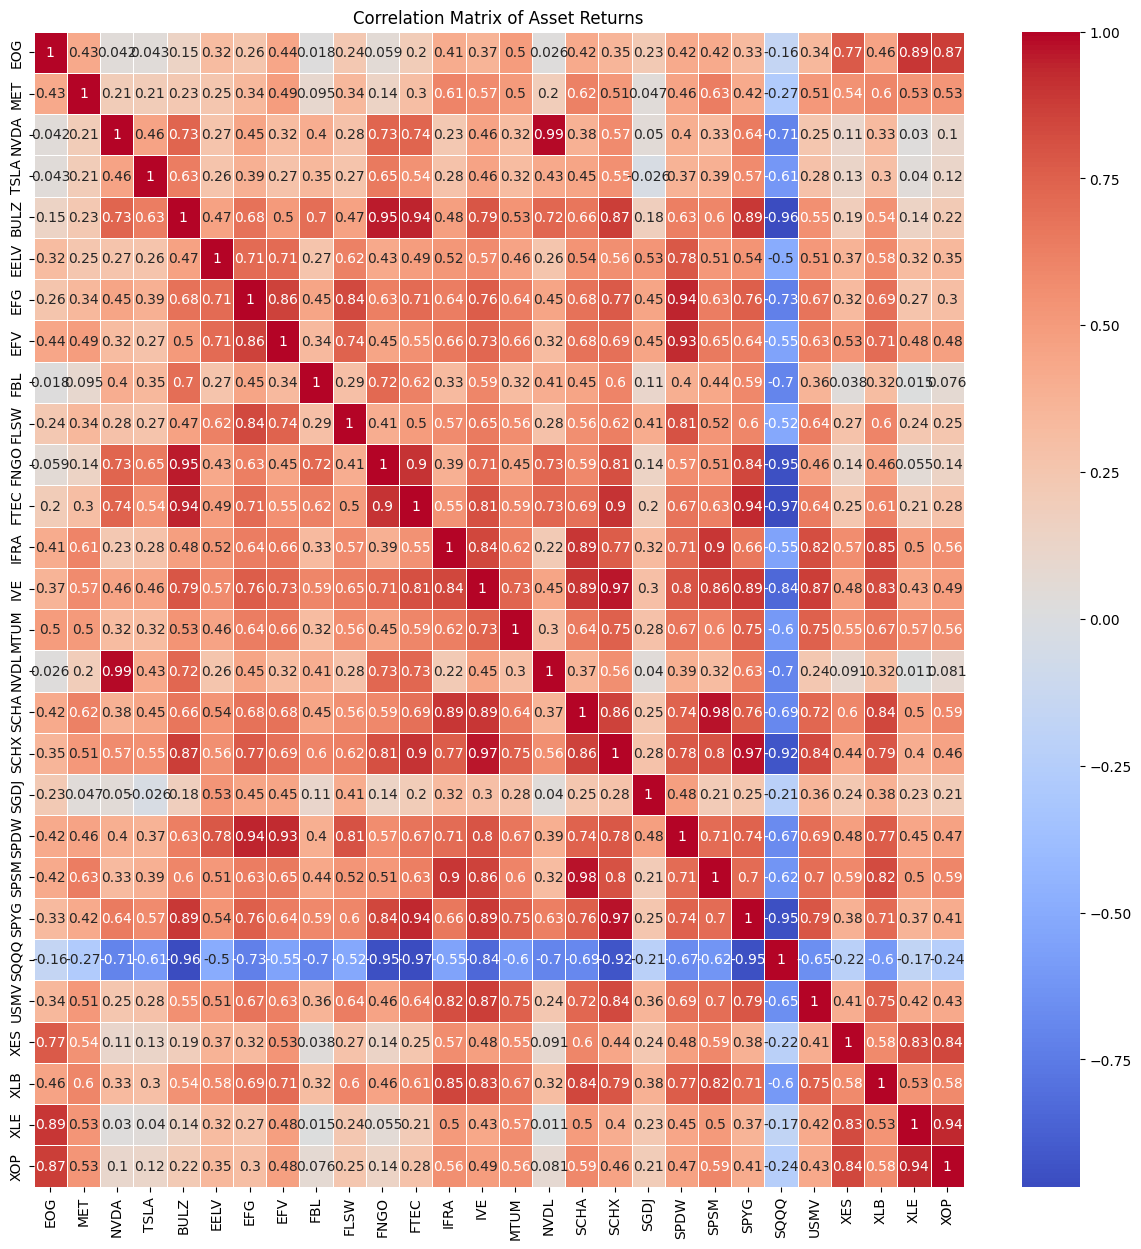

In [22]:
f.plot_correlation_matrix(return_stocks)